<a href="https://colab.research.google.com/github/sakuna47/Customer_Segmentation_with_Clustering/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Upgrade pip, setuptools, and wheel
!pip install --upgrade pip setuptools wheel

# Install pystan (required dependency for Prophet)
!pip install pystan==2.19.1.1

# Install Prophet (fbprophet is now deprecated)
!pip install prophet

# Install other necessary libraries
!pip install pandas numpy matplotlib statsmodels tensorflow scikit-learn





  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


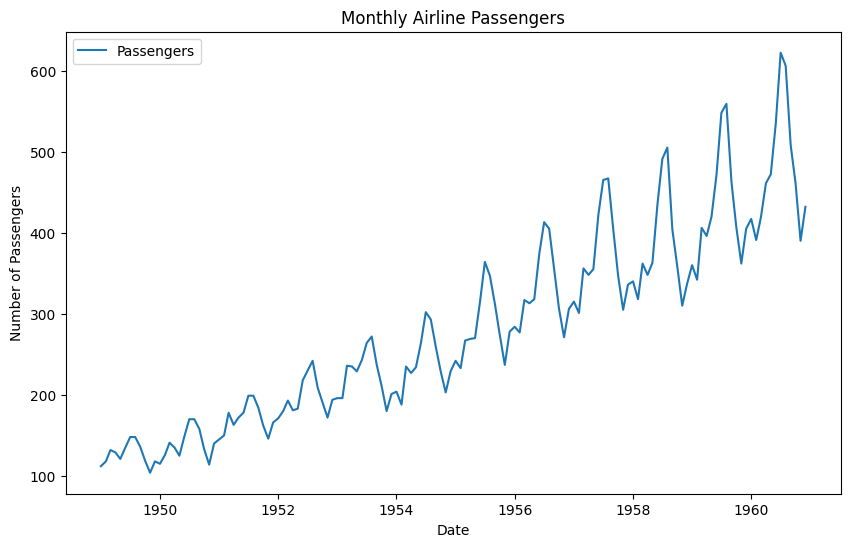

In [8]:
# Explore the dataset
print(df.info())
print(df.describe())

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Passengers'], label='Passengers')
plt.title('Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [9]:
# Preprocess the data
df.index = pd.to_datetime(df.index)
df['Passengers'] = df['Passengers'].astype(float)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -524.549
Date:                Mon, 10 Feb 2025   AIC                           1061.098
Time:                        13:39:18   BIC                           1077.515
Sample:                    01-01-1949   HQIC                          1067.760
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3558      0.092      3.854      0.000       0.175       0.537
ar.L2         -0.2644      0.109     -2.422      0.015      -0.478      -0.050
ar.L3          0.0847      0.078      1.089      0.2

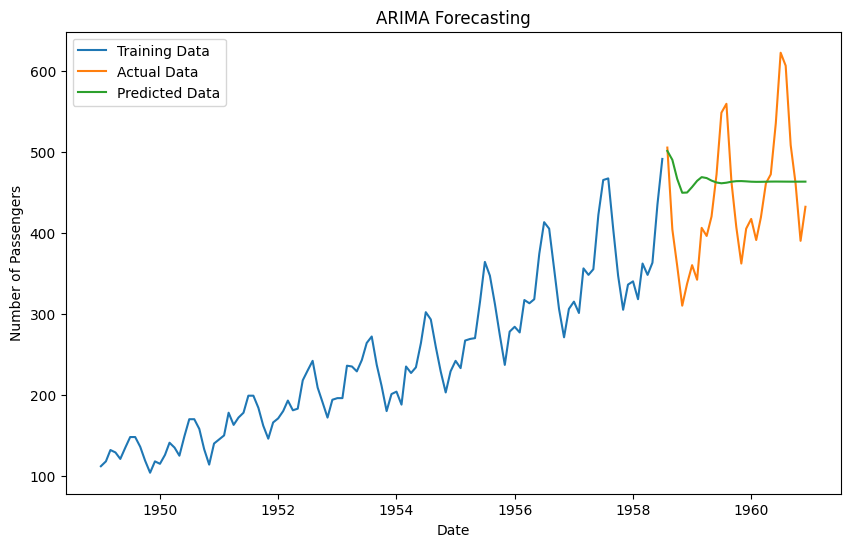

In [10]:
# Build and evaluate ARIMA model
model = ARIMA(train['Passengers'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

predictions = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test['Passengers'], predictions)
mae = mean_absolute_error(test['Passengers'], predictions)
print(f"MSE: {mse}, MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Passengers'], label='Training Data')
plt.plot(test.index, test['Passengers'], label='Actual Data')
plt.plot(test.index, predictions, label='Predicted Data')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp84u5z93t/s47v9xdg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp84u5z93t/993fszjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66309', 'data', 'file=/tmp/tmp84u5z93t/s47v9xdg.json', 'init=/tmp/tmp84u5z93t/993fszjn.json', 'output', 'file=/tmp/tmp84u5z93t/prophet_modell34hid9e/prophet_model-20250210133956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

MSE: 1841.878304962096, MAE: 34.886372200820944


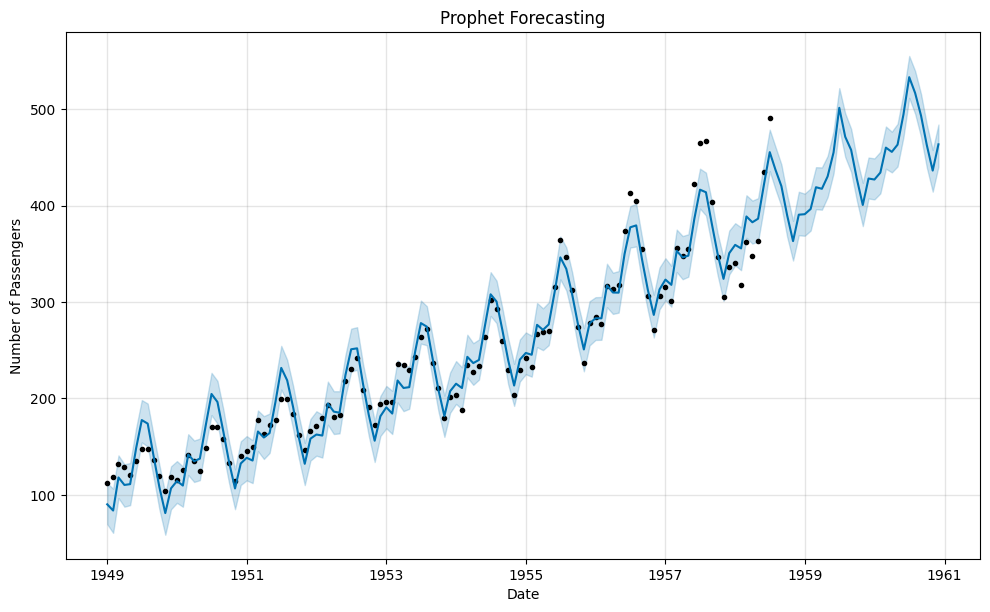

In [11]:
# Build and evaluate Prophet model
prophet_df = train.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})

model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)

predictions = forecast['yhat'][-len(test):]
mse = mean_squared_error(test['Passengers'], predictions)
mae = mean_absolute_error(test['Passengers'], predictions)
print(f"MSE: {mse}, MAE: {mae}")

model.plot(forecast)
plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

In [13]:
import joblib

# Save the ARIMA model
joblib.dump(model_fit, "/content/drive/MyDrive/arima_model.pkl")

# Save the Prophet model
joblib.dump(model, "/content/drive/MyDrive/prophet_model.pkl")

print("ARIMA and Prophet models saved to Google Drive!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/arima_model.pkl'